_The following notebook is a summarised tutorial that is avaialble in full at https://www.raphtory.com/user-guide_

# Loading and Cleaning the data

After reading data into Raphtory we can now make use of the graph representation to ask some interesting questions. For this tutorial, we will use a dataset from [SocioPatterns](http://www.sociopatterns.org/datasets/baboons-interactions/), comprising different behavioural interactions between a group of 22 baboons over a month. 

If you want to read more about the dataset, you can check it out in this paper: [V. Gelardi, J. Godard, D. Paleressompoulle, N. Claidière, A. Barrat, “Measuring social networks in primates: wearable sensors vs. direct observations”, Proc. R. Soc. A 476:20190737 (2020)](https://royalsocietypublishing.org/doi/10.1098/rspa.2019.0737). 

In the below code we load this dataset into a dataframe and do a small amount of preprocessing to prepare it for loading into Raphtory. This includes dropping rows with blank fields and mapping the values of the `behaviour category` into a `weight` which can be aggregated. The mapping consists of the following conversions:

* Affiliative (positive interaction) → `+1`
* Agonistic (negative interaction) → `-1` 
* Other (neutral interaction) → `0`

In [1]:
import pandas as pd

edges_df = pd.read_csv(
    "data/OBS_data.txt", sep="\t", header=0, usecols=[0, 1, 2, 3, 4], parse_dates=[0], date_format='%d/%m/%Y %H:%M'
)
edges_df["DateTime"] =edges_df["DateTime"].astype("datetime64[ms]")
edges_df.dropna(axis=0, inplace=True)
edges_df["Weight"] = edges_df["Category"].apply(
    lambda c: 1 if (c == "Affiliative") else (-1 if (c == "Agonistic") else 0)
)
print(edges_df.head())

              DateTime   Actor Recipient  Behavior     Category  Weight
15 2019-06-13 09:50:00  ANGELE    FELIPE  Grooming  Affiliative       1
17 2019-06-13 09:50:00  ANGELE    FELIPE  Grooming  Affiliative       1
19 2019-06-13 09:51:00  FELIPE    ANGELE   Resting  Affiliative       1
20 2019-06-13 09:51:00  FELIPE      LIPS   Resting  Affiliative       1
21 2019-06-13 09:51:00  ANGELE    FELIPE  Grooming  Affiliative       1


# Creating a graph

There are plenty of ways to get data into Raphtory and start running analysis. In this tutorial we are going to cover loading from a Pandas Dataframe. You can also directly update or loading from a saved graph.

To get started we first need to create a graph to store our data. Printing this graph will show it as empty with no nodes, edges or update times.

In [2]:
import raphtory as rp

g = rp.Graph()
g

Graph(number_of_nodes=0, number_of_edges=0, number_of_temporal_edges=0, earliest_time=None, latest_time=None)

Next we load this into Raphtory using the `load_edges_from_pandas` function, modelling it as a weighted multi-layer graph, with a layer per unique `behaviour`. 

In [3]:
g.load_edges_from_pandas(
    df=edges_df,
    src="Actor",
    dst="Recipient",
    time="DateTime",
    layer_col="Behavior",
    properties=["Weight"],
)
print(g)

Graph(number_of_nodes=22, number_of_edges=290, number_of_temporal_edges=3196, earliest_time=1560419400000, latest_time=1562756700000)


# Basic Metrics

Now that we have our graph let's start probing it for some basic metrics, such as how many nodes and edges it contains and the time range over which it exists. 

Note, as the property APIs are the same for the graph, nodes and edges, these are discussed together in [Property queries](https://www.raphtory.com/user-guide/querying/5_properties/).

In [4]:
print("Stats on the graph structure:")

number_of_nodes = g.count_nodes()
number_of_edges = g.count_edges()
total_interactions = g.count_temporal_edges()
unique_layers = g.unique_layers

print("Number of nodes (Baboons):", number_of_nodes)
print("Number of unique edges (src,dst,layer):", number_of_edges)
print("Total interactions (edge updates):", total_interactions)
print("Unique layers:", unique_layers, "\n")


print("Stats on the graphs time range:")

earliest_datetime = g.earliest_date_time
latest_datetime = g.latest_date_time
earliest_epoch = g.earliest_time
latest_epoch = g.latest_time

print("Earliest datetime:", earliest_datetime)
print("Latest datetime:", latest_datetime)
print("Earliest time (Unix Epoch):", earliest_epoch)
print("Latest time (Unix Epoch):", latest_epoch)

Stats on the graph structure:
Number of nodes (Baboons): 22
Number of unique edges (src,dst,layer): 290
Total interactions (edge updates): 3196
Unique layers: ['_default', 'Touching', 'Resting', 'Carrying', 'Presenting', 'Playing with', 'Grooming', 'Threatening', 'Attacking', 'Embracing', 'Avoiding', 'Grunting-Lipsmacking', 'Supplanting', 'Submission', 'Mounting', 'Copulating', 'Chasing'] 

Stats on the graphs time range:
Earliest datetime: 2019-06-13 09:50:00+00:00
Latest datetime: 2019-07-10 11:05:00+00:00
Earliest time (Unix Epoch): 1560419400000
Latest time (Unix Epoch): 1562756700000


## Accessing nodes and edges  
Three types of functions are provided for accessing the nodes and edges within the graph: 

* **Existance check:** Via `has_node()` and `has_edge()` you can check if an entity is present within the graph.
* **Direct access:** `node()` and `edge()` will return a node/edge object if the entity is present and `None` if it is not.
* **Iterable access:** `nodes` and `edges` will return iterables for all nodes/edges which can be used within a for loop or as part of a [function chain](https://www.raphtory.com/user-guide/querying/6_chaining/).

All of these functions are shown in the code below and will appear in several other examples throughout this tutorial.

In [5]:
print("Checking if specific nodes and edges are in the graph:")
if g.has_node(id="LOME"):
    print("Lomme is in the graph")
if g.layer("Playing with").has_edge(src="LOME", dst="NEKKE"):
    print("Lomme has played with Nekke \n")

print("Getting individual nodes and edges:")
print(g.node("LOME"))
print(g.edge("LOME", "NEKKE"), "\n")

print("Getting iterators over all nodes and edges:")
print(list(g.nodes)[:5])
print(list(g.edges)[:3])

Checking if specific nodes and edges are in the graph:
Lomme is in the graph
Lomme has played with Nekke 

Getting individual nodes and edges:
Node(name=LOME, earliest_time=1560419520000, latest_time=1562756100000)
Edge(source=LOME, target=NEKKE, earliest_time=1560421080000, latest_time=1562755980000, properties={Weight: 1}, layer(s)=[Touching, Resting, Carrying, Playing with, Grooming]) 

Getting iterators over all nodes and edges:
[Node(name=MALI, earliest_time=1560422040000, latest_time=1562755320000), Node(name=FEYA, earliest_time=1560420000000, latest_time=1562756040000), Node(name=FANA, earliest_time=1560420000000, latest_time=1562754600000), Node(name=EWINE, earliest_time=1560442020000, latest_time=1562754600000), Node(name=MAKO, earliest_time=1560421620000, latest_time=1562756100000)]
[Edge(source=ARIELLE, target=PETOULETTE, earliest_time=1560437700000, latest_time=1561626660000, properties={Weight: 1}, layer(s)=[Resting, Grooming]), Edge(source=FEYA, target=FANA, earliest_time

# Update history

In the code below we create a node object for the monkey Felipe and see when their updates occurred. 

We've limited Felipes updates to the first 10 since they have had many interactions! 


In [6]:
v = g.node("FELIPE")
print(
    f"{v.name}'s first interaction was at {v.earliest_date_time} and their last interaction was at {v.latest_date_time}\n"
)
print(f"{v.name} had interactions at the following times: {v.history()[:10]}\n")

FELIPE's first interaction was at 2019-06-13 09:50:00+00:00 and their last interaction was at 2019-07-10 11:05:00+00:00

FELIPE had interactions at the following times: [1560419400000 1560419460000 1560419520000 1560419580000 1560419640000
 1560420720000 1560421260000 1560422580000 1560423360000 1560423420000]



# Neighbours, edges and paths


To investigate who a node is connected with we can ask for its `degree()`, `edges`, or `neighbours`. As Raphtory is a directed graph all of these functions also have an `in_` and `out_` variation, allowing you get only incoming and outgoing connections respectively. These functions return the following:

* **degree:** A count of the number of unique connections a node has.
* **edges:** An iterable (`Edges`) of edge objects, one for each unique `(src,dst)` pair.
* **neighbours:** An iterable of node objects (`PathFromNode`), one for each node the node shares an edge with.

Let's look at `Felipe` and find their degrees and neighbours.  

In [7]:
v = g.node("FELIPE")
v_name = v.name
in_degree = v.in_degree()
out_degree = v.out_degree()
in_edges = v.in_edges
neighbours = v.neighbours
neighbour_names = v.neighbours.name.collect()

print(
    f"{v_name} has {in_degree} incoming interactions and {out_degree} outgoing interactions.\n"
)

print(list(in_edges)[:3])
print(list(neighbours)[:3], "\n")
print(f"{v_name} interacted with the following baboons {neighbour_names}")


FELIPE has 17 incoming interactions and 18 outgoing interactions.

[Edge(source=MALI, target=FELIPE, earliest_time=1561117140000, latest_time=1562753160000, properties={Weight: 1}, layer(s)=[Resting, Presenting, Grooming]), Edge(source=FEYA, target=FELIPE, earliest_time=1560853500000, latest_time=1562586000000, properties={Weight: 1}, layer(s)=[Resting, Presenting]), Edge(source=FANA, target=FELIPE, earliest_time=1560526140000, latest_time=1562752800000, properties={Weight: 1}, layer(s)=[Touching, Resting, Presenting, Grooming, Submission, Copulating])]
[Node(name=MALI, earliest_time=1560422040000, latest_time=1562755320000), Node(name=FEYA, earliest_time=1560420000000, latest_time=1562756040000), Node(name=FANA, earliest_time=1560420000000, latest_time=1562754600000)] 

FELIPE interacted with the following baboons ['MALI', 'FEYA', 'FANA', 'EWINE', 'MAKO', 'ANGELE', 'LOME', 'BOBO', 'MUSE', 'NEKKE', 'PETOULETTE', 'ARIELLE', 'HARLEM', 'ATMOSPHERE', 'LIPS', 'PIPO', 'VIOLETTE', 'SELF']


## Exploded edges
The very first question you may have after reading this is "What if I don't want all of the layers?" For this Raphtory offers you three different ways to split the edge, depending on your use case:

* `.layers()`: which takes a list of layer names and returns a new `Edge View` which only contains updates for the specified layers - This is discussed in more detail in the [Layer views](https://www.raphtory.com/user-guide/views/3_layer/) chapter.
* `.explode_layers()`: which returns an iterable of `Edge Views`, each containing the updates for one layer.
* `.explode()`: which returns an `Exploded Edge` containing only the information from one call to `add_edge()` i.e. an edge object for each update. 

In the code below you can see usage of all of these functions. We first call `explode_layers()`, seeing which layer each edge object represents and output its update history. Next we fully `explode()` the edge and see each update as an individual object. Thirdly we use the `layer()` function to look at only the `Touching` and `Carrying` layers and chain this with a call to `explode()` to see the updates within these individually. 

Each update below has been truncated to only show the first five. 

In [8]:
print("Update history per layer:")
for e in list(g.edge("FELIPE", "MAKO").explode_layers())[:5]:
    print(f"{e.src.name} interacted with {e.dst.name} with the following behaviour '{e.layer_name}' at this times: {e.history()}")


print()
print("Individual updates as edges:")
for e in list(g.edge("FELIPE", "MAKO").explode())[:5]:
    print(f"At {e.date_time} {e.src.name} interacted with {e.dst.name} in the following manner: '{e.layer_name}'")

print("...\n")
print("Individual updates for 'Touching' and 'Carrying:")
for e in list(g.edge("FELIPE", "MAKO").layers(["Touching", "Carrying"]).explode())[:5]:
    print(f"At {e.date_time} {e.src.name} interacted with {e.dst.name} in the following manner: '{e.layer_name}'")
print("...\n")

Update history per layer:
FELIPE interacted with MAKO with the following behaviour 'Touching' at this times: [1562149020000]
FELIPE interacted with MAKO with the following behaviour 'Resting' at this times: [1560437400000 1560437640000 1560935460000 1561117620000 1561373880000
 1561390860000 1561390860000 1561390860000 1561643580000 1561970760000
 1562149020000 1562671020000]
FELIPE interacted with MAKO with the following behaviour 'Carrying' at this times: [1561043280000 1561373940000]
FELIPE interacted with MAKO with the following behaviour 'Playing with' at this times: [1561373880000 1561373940000 1561373940000 1561390920000 1562148960000
 1562148960000 1562149080000]
FELIPE interacted with MAKO with the following behaviour 'Grooming' at this times: [1561043280000 1561043340000]

Individual updates as edges:
At 2019-06-13 14:50:00+00:00 FELIPE interacted with MAKO in the following manner: 'Resting'
At 2019-06-13 14:54:00+00:00 FELIPE interacted with MAKO in the following manner: 'Re

# Chaining Functions 

When we called `v.neighbours` in [Node metrics](https://www.raphtory.com/user-guide/querying/3_node-metrics/#neighbours-edges-and-paths), a `PathFromNode` was returned rather than a `List`. This, along with all other iterables previously mentioned (`Nodes`,`Edges`,`Properties`), are [lazy](https://en.wikipedia.org/wiki/Lazy_evaluation) data structures which allow you to chain multiple functions together before a final execution. 

For example, for a node `v`, `v.neighbours.neighbours` will return the two-hop neighbours. The first call of `neighbours` returns the immediate neighbours of `v`, the second applies the`neighbours` function to each of the nodes returned by the first call. 

We can continue this chain for as long as we like, with any functions in the Node, Edge or Property API until we either: 

* Call `.collect()`, which will execute the chain and return the result.
* Execute the chain by handing it to a python function such as `list()`, `set()`, `sum()`, etc.
* Iterate through the chain via a loop/list comprehension.

We can see a basic example of these function chains below in which we get the names of all the monkeys, the names of their two-hop neighbours, zip these together and print the result.

For clarity, we have limited the out to show the first 15 monkeys and their first 10 two-hop neighbours. 

In [9]:
node_names = g.nodes.name
two_hop_neighbours = g.nodes.neighbours.neighbours.name.collect()
combined = zip(node_names, two_hop_neighbours)
for name, two_hop_neighbour in list(combined)[:15]:
    print(f"{name} has the following two hop neighbours {list(two_hop_neighbour)[:10]}") 

MALI has the following two hop neighbours ['MALI', 'FEYA', 'FANA', 'EWINE', 'MAKO', 'ANGELE', 'LOME', 'BOBO', 'MUSE', 'NEKKE']
FEYA has the following two hop neighbours ['MALI', 'FEYA', 'FANA', 'EWINE', 'MAKO', 'ANGELE', 'LOME', 'BOBO', 'MUSE', 'NEKKE']
FANA has the following two hop neighbours ['MALI', 'FEYA', 'FANA', 'EWINE', 'MAKO', 'ANGELE', 'LOME', 'BOBO', 'MUSE', 'NEKKE']
EWINE has the following two hop neighbours ['MALI', 'FEYA', 'FANA', 'EWINE', 'MAKO', 'ANGELE', 'LOME', 'BOBO', 'MUSE', 'NEKKE']
MAKO has the following two hop neighbours ['MALI', 'FEYA', 'FANA', 'EWINE', 'MAKO', 'ANGELE', 'LOME', 'BOBO', 'MUSE', 'NEKKE']
ANGELE has the following two hop neighbours ['MALI', 'FEYA', 'FANA', 'EWINE', 'MAKO', 'ANGELE', 'LOME', 'BOBO', 'MUSE', 'NEKKE']
LOME has the following two hop neighbours ['MALI', 'FEYA', 'FANA', 'EWINE', 'MAKO', 'ANGELE', 'LOME', 'BOBO', 'MUSE', 'NEKKE']
BOBO has the following two hop neighbours ['MALI', 'FEYA', 'FANA', 'EWINE', 'MAKO', 'ANGELE', 'LOME', 'BOBO'

# Chains with properties 

To demonstrate this question, we can include some property aggregation into our chains. 

In the code below we sum the `Weight` value of each of `Felipe's` out-neighbours to rank them by the number of positive interactions he has initiated with them. 

Following this find the most annoying monkey by ranking globally who on average has had the most negative interactions initiated against them.

In [10]:
v = g.node("FELIPE")
neighbours_weighted = list(
    zip(
        v.out_edges.dst.name,
        v.out_edges.properties.temporal.get("Weight").values().sum(),
    )
)
sorted_weights = sorted(neighbours_weighted, key=lambda v: v[1], reverse=True)
print(f"Felipe's favourite baboons in descending order are {sorted_weights}")

annoying_monkeys = list(
    zip(
        g.nodes.name,
        g.nodes.in_edges.properties.temporal.get("Weight")
        .values()
        .sum()  # sum the weights within each edge
        .mean()  # average the summed weights for each monkey
        .collect(),
    )
)
most_annoying = sorted(annoying_monkeys, key=lambda v: v[1])[0]
print(
    f"{most_annoying[0]} is the most annoying monkey with an average score of {most_annoying[1]}"
)


Felipe's favourite baboons in descending order are [('NEKKE', 41), ('ANGELE', 31), ('MAKO', 26), ('LOME', 23), ('LIPS', 11), ('HARLEM', 10), ('FANA', 8), ('MALI', 6), ('FEYA', 5), ('EWINE', 5), ('ARIELLE', 5), ('PIPO', 3), ('SELF', 2), ('BOBO', 1), ('PETOULETTE', 1), ('ATMOSPHERE', 1), ('VIOLETTE', 1), ('MUSE', -1)]
EXTERNE is the most annoying monkey with an average score of -2.0


# Graph Views


Raphtory can maintain hundreds of thousands of Graph Views in parallel, allows chaining view functions together to create as specific a filter as is required for your use case, and provides a unified API such that all functions mentioned can be called on a graph, node or edge.

There are a number of views supported, such as `before()` takes a time argument in epoch (integer) or datetime (string/datetime object) format and can be called on a graph, node, or edge. This will return an equivalent Graph View, Node View or Edge View which includes all updates between the beginning of the graphs history and the provided time (exclusive of the time provided). 

You can also apply windows with the `window()` function. This allows you to set a start time as well as an end time (inclusive of start, exclusive of end).

This is useful for digging into specific ranges of the history that you are interested in, for example a given day within your data, filtering everything else outside this range. An example of this can be seen below where we look at the number of times Lome interacts wth Nekke within the full dataset and for one day between the 13th of June and the 14th of June.

In [11]:
from datetime import datetime

start_day = datetime.strptime("2019-06-13", "%Y-%m-%d")
end_day = datetime.strptime("2019-06-14", "%Y-%m-%d")
v_at_2 = g.before(1560428239000).node("LOME")  # 13/06/2019 12:17:19 as epoch
e = g.edge("LOME", "NEKKE")
print(
    f"Across the full dataset {e.src.name} interacted with {e.dst.name} {len(e.history())} times"
)
e = e.window(start_day, end_day)
print(
    f"Between {v_at_2.start_date_time} and {v_at_2.end_date_time}, {e.src.name} interacted with {e.dst.name} {len(e.history())} times"
)
print(
    f"Window start: {e.start_date_time}, First update: {e.earliest_date_time}, Last update: {e.latest_date_time}, Window End: {e.end_date_time}"
)


Across the full dataset LOME interacted with NEKKE 41 times
Between None and 2019-06-13 12:17:19+00:00, LOME interacted with NEKKE 8 times
Window start: 2019-06-13 00:00:00+00:00, First update: 2019-06-13 10:18:00+00:00, Last update: 2019-06-13 15:05:00+00:00, Window End: 2019-06-14 00:00:00+00:00


## Rolling




Where `at()` has `expanding()`, `window()` has `rolling()`. This function will return an iterable of views, incrementing by a `window` size and only including the history from inside the window period (**Inclusive of start, exclusive of end**). This allows you to easily extract daily or monthly metrics.

`rolling()` takes an option `step` argument which specifies how far along the timeline it should increment before applying the next window. By default this is the same as `window`, allowing all updates to be analysed exactly once in non-overlapping windows.

We use the `rolling()` function, to analyse `Lome's` daily interactions, with the step being `1 day`

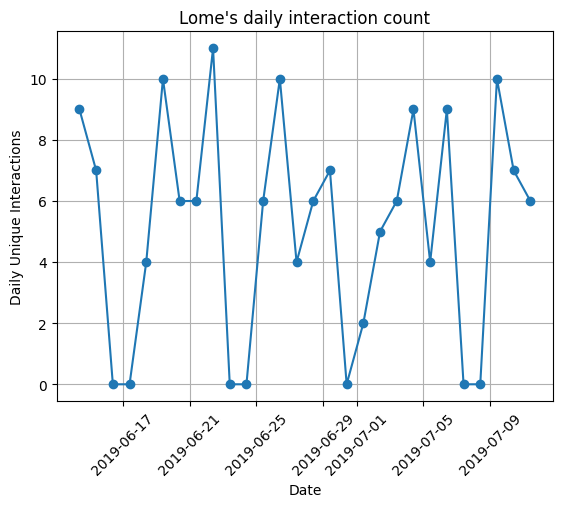

In [12]:
import matplotlib.pyplot as plt
importance = []
time = []
for rolling_lome in g.node("LOME").rolling("1 day"):
    importance.append(rolling_lome.degree())
    time.append(rolling_lome.end_date_time)

plt.plot(time, importance, marker="o")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Daily Unique Interactions")
plt.title("Lome's daily interaction count")
plt.grid(True)

## Layered Graphs

 As previously discussed, an edge object by default will contain information on all layers between its source and destination nodes. However, it is often the case that there are a subset of these relationships that we are interested in. To handle this the `Graph`, `Node` and `Edge` provide the `layers()` function. 

 This takes a list of layer names and returns a view with only edge updates that occurred on these layers. Layer views will pass their restrictions on to any object they return (as with the time views) and can be used in combination with any other view function.

 As an example of this, in the code below we look at the total edge weight over the full graph, then restrict this to the `Grooming` and `Resting` layers and then reduce this further by applying a window between the 13th and 20th of June.

In [13]:
total_weight = g.edges.properties.temporal.get("Weight").values().sum().sum()
print(f"Total weight across all edges is {total_weight}.")

total_weight = (
    g.layers(["Grooming", "Resting"])
    .edges.properties.temporal.get("Weight")
    .values()
    .sum()
    .sum()
)
print(f"Total weight across Grooming and Resting is {total_weight}.")

start_day = datetime.strptime("2019-06-13", "%Y-%m-%d")
end_day = datetime.strptime("2019-06-20", "%Y-%m-%d")
total_weight = (
    g.layers(["Grooming", "Resting"])
    .window(start_day, end_day)
    .edges.properties.temporal.get("Weight")
    .values()
    .sum()
    .sum()
)
print(
    f"Total weight across Grooming and Resting between {start_day} and {end_day} is {total_weight}."
)

Total weight across all edges is 2948.
Total weight across Grooming and Resting is 1685.
Total weight across Grooming and Resting between 2019-06-13 00:00:00 and 2019-06-20 00:00:00 is 403.


## Subgraph
Similar to only being interested in a subset of edge layers, for some use cases we may only be interested in a subset of nodes within the graph. One solution to this could be to call `g.nodes` and filter this before continuing your workflow. However, this does not remove anything for later calls to `neighbours`, `edges`, etc. Meaning you will have to constantly recheck these lists. 

To handle all of these corner cases Raphtory provides the `subgraph()` function which takes a list of nodes of interest. This applies a view such that all nodes not in the list are hidden from all future function calls. This also hides any edges linked to hidden nodes to keep the subgraph consistent. 

In the below example we demonstrate this by looking at the neighbours of `FELIPE` in the full graph, vs a subgraph of `FELIPE`, `LIPS`, `NEKKE`, `LOME` and `BOBO`. We also show how that `subgraph()` can be combined with other view functions, in this case a window between the 17th and 18th of June.


In [14]:
print(f"There are {g.count_nodes()} monkeys in the whole graph")
subgraph = g.subgraph(["FELIPE", "LIPS", "NEKKE", "LOME", "BOBO"])
print(f"There are {subgraph.count_nodes()} monkeys in the subgraph")
neighbours = g.node("FELIPE").neighbours.name.collect()
print(f"FELIPE has the following neighbours in the full graph: {neighbours}")
neighbours = subgraph.node("FELIPE").neighbours.name.collect()
print(f"FELIPE has the following neighbours in the subgraph: {neighbours}")
start_day = datetime.strptime("2019-06-17", "%Y-%m-%d")
end_day = datetime.strptime("2019-06-18", "%Y-%m-%d")
neighbours = (
    subgraph.node("FELIPE").window(start_day, end_day).neighbours.name.collect()
)
print(
    f"FELIPE has the following neighbours in the subgraph between {start_day} and {end_day}: {neighbours}"
)

There are 22 monkeys in the whole graph
There are 5 monkeys in the subgraph
FELIPE has the following neighbours in the full graph: ['MALI', 'FEYA', 'FANA', 'EWINE', 'MAKO', 'ANGELE', 'LOME', 'BOBO', 'MUSE', 'NEKKE', 'PETOULETTE', 'ARIELLE', 'HARLEM', 'ATMOSPHERE', 'LIPS', 'PIPO', 'VIOLETTE', 'SELF']
FELIPE has the following neighbours in the subgraph: ['LOME', 'BOBO', 'NEKKE', 'LIPS']
FELIPE has the following neighbours in the subgraph between 2019-06-17 00:00:00 and 2019-06-18 00:00:00: ['NEKKE']


# Running Algorithms 

Within Raphtory we have implemented many of the standard algorithms you may expect within a graph library, but have also added several temporal algorithms such as `Temporal Reachability` and `Temporal Motifs`. You can check out the full list of available algorithms [here](https://docs.raphtory.com/en/master/reference/algorithms/index.html) and edit the code snippets below in your own notebook to test them out. 

## Graph wide algorithms
The first category of algorithms we can run are `graph wide`, returning one value for the whole graph. There are many useful metrics that fall into this category, of which we run three in the code below:

* [Graph Density](https://en.wikipedia.org/wiki/Dense_graph) - which represents the ratio between the edges present in a graph and the maximum number of edges that the graph could contain.
* [Clustering coefficient](https://en.wikipedia.org/wiki/Clustering_coefficient) - which is a measure of the degree to which nodes in a graph tend to cluster together e.g. how many of your friends are also friends.
* [Reciprocity](https://en.wikipedia.org/wiki/Reciprocity_(network_science)) - which is a measure of the likelihood of nodes in a directed network to be mutually connected e.g. if you follow someone on twitter, whats the change of them following you back.

As you can see below, to run an algorithm you simply need to import the algorithm package, choose an algorithm to run and hand it your graph.

In [15]:
from raphtory import algorithms as rp

density = rp.directed_graph_density(g)
clustering_coefficient = rp.global_clustering_coefficient(g)
reciprocity = rp.global_reciprocity(g)

print(f"The graph's density is {density}")
print(f"The graph's clustering coefficient is {clustering_coefficient}")
print(f"The graph's reciprocity is {reciprocity}")

The graph's density is 0.6277056277056277
The graph's clustering coefficient is 0.917550058892815
The graph's reciprocity is 0.8819444444444444


## Node centric algorithms 
The second category of algorithms are `node centric` and return a value for each node in the graph. These results are stored within a [AlgorithmResult](https://docs.raphtory.com/en/master/reference/algorithms/algorithmresult.html) object which has functions for sorting, grouping, top_k and conversion to dataframes. To demonstrate these functions below we have run [PageRank](https://en.wikipedia.org/wiki/PageRank) and [Weakly Connected Components](https://en.wikipedia.org/wiki/Component_(graph_theory)).

## Continuous Results (PageRank)
`PageRank` is an centrality metric developed by Google's founders to rank web pages in search engine results based on their importance and relevance. This has since become a standard ranking algorithm for a whole host of other usecases.

Raphtory's implementation returns the score for each node - these are continuous values, meaning we can discover the most important monekys in our dataset via `top_k()`.

In the code below we first get the result of an individual monkey (Nekke), followed by the values of the top 5 most important monkeys. 

In [16]:
from raphtory import algorithms as rp

results = rp.pagerank(g)

# Getting the results for an individual monkey (NEKKE)
nekke_rank = results.get("NEKKE")
print(f"Nekkes's ranking is {nekke_rank}\n")

# Getting the top 5 most important characters and printing out their scores
top_5 = results.top_k(5)
for rank, (name, score) in enumerate(top_5.items(), 1):
    print(f"Rank {rank}: {name} with a score of {score:.5f}")

Nekkes's ranking is 0.05593041224988802

Rank 1: Node(name=PETOULETTE, earliest_time=1560422520000, latest_time=1562754420000) with a score of 0.05990
Rank 2: Node(name=BOBO, earliest_time=1560419520000, latest_time=1562755500000) with a score of 0.05941
Rank 3: Node(name=LIPS, earliest_time=1560419460000, latest_time=1562756700000) with a score of 0.05812
Rank 4: Node(name=FELIPE, earliest_time=1560419400000, latest_time=1562756700000) with a score of 0.05788
Rank 5: Node(name=VIOLETTE, earliest_time=1560423600000, latest_time=1562754900000) with a score of 0.05759


## Running algorithms on graph views 

As with all the queries we above, both `graphwide` and `node centric` algorithms can be run on `graph views`. This allows us to see how results change over time, run algorithms on subsets of the layers or remove specific nodes from the graph to see the impact this has. 

To demonstrate this, below is an example of how you could track Nekkes's importance using rolling windows and the `PageRank` algorithm. 

Within each windowed graph we use the api to extract Nekke's score and record it alongside the earliest timestamp in the window, which can then be plotted via matplotlib.

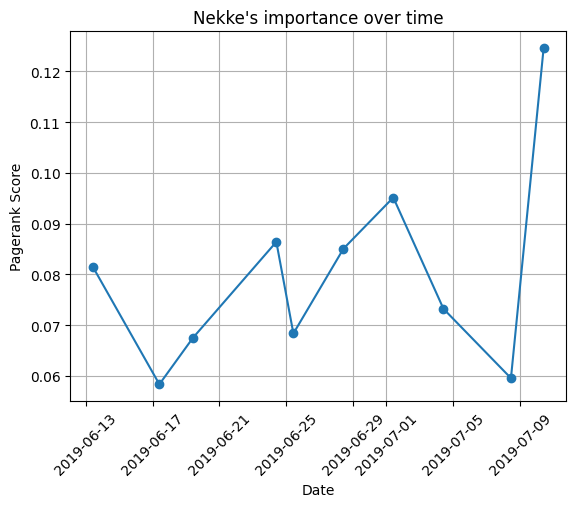

In [17]:
from datetime import datetime

importance = []
time = []

for windowed_graph in g.rolling(window="3 days"):
    result = rp.pagerank(windowed_graph)
    importance.append(result.get("NEKKE"))
    time.append(windowed_graph.earliest_date_time)

plt.plot(time, importance, marker="o")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Pagerank Score")
plt.title("Nekke's importance over time")
plt.grid(True)